In [35]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from time import sleep, time
from datetime import timedelta
from hashlib import md5, sha1
from tqdm.notebook import tqdm
from urllib.request import urlretrieve
from concurrent.futures import ThreadPoolExecutor

In [36]:
rdf = pd.read_csv('catalog_categorization_new_dataset_unload.csv')
rdf.head()

,id_product_config,product_name,product_description,gender,color,brand,original_price,product_small_image,product_large_image,cmc_division,box_weight,box_length,box_height,box_width,category_bob
0,1253970,Mochila HB Box,<h3>Transporte seus pertences com estilo usand...,Unissex,Azul,HB,99.9,http://img.kstatic.com.br/p/0-93862-1-cart.jpg,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,Sports Accessories,0.80,11.0,48.0,37.0,Mochila
1,1256596,Boné Quiksilver Piping,<h3>Esbanje estilo e atitude por aí com o Boné...,Masculino,Branco,Quiksilver,139.0,http://img.kstatic.com.br/p/0-42946-1-cart.jpg,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,Sports Accessories,0.09,20.0,3.0,18.0,Boné
2,1258255,Blusa Eclectic Tricot Aleta Courinho,<h3>Com a Blusa Eclectic Tricot Aleta Courinho...,Feminino,Marrom,Eclectic,179.9,http://img.kstatic.com.br/p/0-37283-1-cart.jpg,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,Sports Apparel,0.22,26.0,3.0,33.0,Blusa
3,1258915,Camiseta Regata Quiksilver In The Zone,<strong>Camiseta Regata Quiksilver In The Zone...,Masculino,Amarelo Claro,Quiksilver,84.9,http://img.kstatic.com.br/p/0-102442-1-cart.jpg,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,Sports Apparel,0.15,2.0,29.0,25.0,Camiseta
4,1259416,Mochila Quiksilver Recess Full Five,<h3>Leve tudo o que você precisa com muito est...,Unissex,Colorido,Quiksilver,129.9,http://img.kstatic.com.br/p/0-4868-1-cart.jpg,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,Sports Accessories,1.20,37.0,48.0,11.0,Mochila


In [37]:
df = pd.DataFrame()

#product config anonymization
df['product_id'] = rdf['id_product_config']#.factorize()[0] # why not?
df['product_id'] = df['product_id'].apply(lambda x: f'schblaum){x:07d}(HUIDASV$8U14') # salt and pepper
df['product_id'] = df['product_id'].apply(lambda x: (md5(x.encode()).hexdigest()).upper()) # hash

df['product_name'] = rdf['product_name']
df['product_description'] = rdf['product_description']
df['gender'] = rdf['gender']
df['color'] = rdf['color']
df['brand'] = rdf['brand']
# df['brand_id'] = rdf['brand'].factorize()[0] # maybe should not label encode?

# add 
random_discount_min_max = (0.9, 1.1)
df['price'] = round(rdf['original_price']*(np.random.random_sample(size=(df.shape[0],))*(random_discount_min_max[1] - random_discount_min_max[0]) + random_discount_min_max[0] ), 2)
df['price'] = round(df['price']/5)*5 - 0.01

random_discount_min_max = (0.6, 0.9)
df['special_price'] = round(rdf['original_price']*(np.random.random_sample(size=(df.shape[0],))*(random_discount_min_max[1] - random_discount_min_max[0]) + random_discount_min_max[0] ), 2)
df['special_price'] = round(df['special_price']/5)*5 - 0.01


df['division'] = rdf['cmc_division']
df['box_weight'] = round(rdf['box_weight']*7.43 + 1.2,1) # whatever transformation
df['box_length'] = round(rdf['box_length']*7.43 + 1.2,1) # whatever transformation
df['box_height'] = round(rdf['box_height']*7.43 + 1.2,1) # whatever transformation
df['box_width'] = round(rdf['box_width']*7.43 + 1.2,1) # whatever transformation
df['product_large_image'] = rdf['product_large_image']
df['product_small_image'] = rdf['product_small_image']
df['category'] = rdf['category_bob']

assert df.product_id.value_counts().max() == 1 # no repeated ids
# del rdf

df.head()

,product_id,product_name,product_description,gender,color,brand,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,product_small_image,category
0,2AF8EBDBE57CC56A2357DE986AD0570C,Mochila HB Box,<h3>Transporte seus pertences com estilo usand...,Unissex,Azul,HB,109.99,74.99,Sports Accessories,7.1,82.9,357.8,276.1,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,http://img.kstatic.com.br/p/0-93862-1-cart.jpg,Mochila
1,62D15191D7E772D1550C6BC43E313D11,Boné Quiksilver Piping,<h3>Esbanje estilo e atitude por aí com o Boné...,Masculino,Branco,Quiksilver,129.99,84.99,Sports Accessories,1.9,149.8,23.5,134.9,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,http://img.kstatic.com.br/p/0-42946-1-cart.jpg,Boné
2,EA51FF4DAE82DA43460709459186E49F,Blusa Eclectic Tricot Aleta Courinho,<h3>Com a Blusa Eclectic Tricot Aleta Courinho...,Feminino,Marrom,Eclectic,189.99,154.99,Sports Apparel,2.8,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,http://img.kstatic.com.br/p/0-37283-1-cart.jpg,Blusa
3,2B6E91B4AEB1BF52A15631C009E04129,Camiseta Regata Quiksilver In The Zone,<strong>Camiseta Regata Quiksilver In The Zone...,Masculino,Amarelo Claro,Quiksilver,89.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,http://img.kstatic.com.br/p/0-102442-1-cart.jpg,Camiseta
4,7741851644EBA94C29D17E5F3BB144F7,Mochila Quiksilver Recess Full Five,<h3>Leve tudo o que você precisa com muito est...,Unissex,Colorido,Quiksilver,119.99,114.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,http://img.kstatic.com.br/p/0-4868-1-cart.jpg,Mochila


In [38]:
for col in ['gender', 'color', 'brand', 'division', 'category']:
    print('\n\n >>>', col)
    print(df[col].value_counts())



 >>> gender
Masculino          123627
Feminino            34068
Unissex              4702
Infanto-Juvenil      2605
Juvenil                35
Name: gender, dtype: int64


 >>> color
Preto               30938
Branco              17606
Azul                13032
Cinza                9775
Vermelho             5940
                    ...  
Carmim Carnáceo         1
Cardo                   1
Creme de Marisco        1
Branco Navajo           1
Pérola                  1
Name: color, Length: 257, dtype: int64


 >>> brand
Rip Curl                8923
Quiksilver              7140
Hurley                  6571
Billabong               5383
Kanui Clothing & Co.    5165
                        ... 
Garmin                     1
GoPro                      1
Converse Skateboard        1
Torian                     1
ReaFitness Brasil          1
Name: brand, Length: 438, dtype: int64


 >>> division
Sports Apparel        104841
Sports Accessories     23290
Sports Shoes           20858
Men - PL         

# Download images

In [39]:
def download_image(url_filename):
        (url, filename) = url_filename
        try:
            urlretrieve(url, filename)
        except:
            return 0
        else:
            return 1

_PATH_TO_SAVE_IMAGES = './images_75x75/'
        
def download_images_from_dataframe(df, max_workers):
    urls = df['product_small_image']
    filenames = _PATH_TO_SAVE_IMAGES + df['product_id'] + '.jpg'
    with ThreadPoolExecutor(max_workers = max_workers) as pool:
        results = pool.map(download_image, zip(urls, filenames))
    return results

def split_dataframe_in_chunks(df, chunksize):
    ntotal = df.shape[0]
    ind = list(range(0,ntotal,chunksize)) + [ntotal]
    df_list = [df[ind[i]:ind[i+1]] for i in range(len(ind)-1)]
    print(f'Split the dataframe in {len(df_list)} chunks.')
    return df_list

def check_existing_images(df):
    filenames = _PATH_TO_SAVE_IMAGES + df['product_id'] + '.jpg'
    exists = [ (1 if os.path.isfile(file) else 0) for file in filenames ]
    print(f'{np.sum(exists)} of {len(filenames)} files ({100*np.sum(exists)/len(filenames):.1f}%) are already downloaded.')
    return exists

def download_images_in_chunks(df, chunksize=100, max_workers=1, start_chunk=0, last_chunk=None):
    df_list = split_dataframe_in_chunks(df, chunksize)
    df_list = df_list[start_chunk:last_chunk]
    status=[]
    total = len(df_list)
    
    start_time = time()
    current_time = start_time
    for i, chunk in enumerate(df_list):
        chunk_status = list(download_images_from_dataframe(chunk, max_workers))
        
        (current_time, last_time) = (time(), current_time)
        total_time = current_time - start_time
        lap_time = current_time - last_time
        remaining_time = (total_time/(i+1))*(total-(i+1))
        n_succ = np.sum(chunk_status)
        n_fail = total - n_succ

        print(f'{i:>10d} of {total:<10d} --- {n_succ:>10d} succedded, {n_fail:>10d} failed     |     Lap: {str(timedelta(seconds=lap_time))} s, Total: {str(timedelta(seconds=total_time))} s, Remaining: {str(timedelta(seconds=remaining_time))} s')
        status += chunk_status
        sleep(2)
        
    print(f'Tried to download {df.shape[0]} images.')
    print(f'Succeeded to download {np.sum(status)}.')
    print(f'Failed to download {df.shape[0] - np.sum(status)}.')
    return status   

In [40]:
IF_ANY_EXISTS_DO_NOT_EVEN_TRY_TO_DOWNLOAD=True

In [41]:
exists = check_existing_images(df)
df['already_exists'] = exists

if IF_ANY_EXISTS_DO_NOT_EVEN_TRY_TO_DOWNLOAD and (df['already_exists']==1).any():
    df['download_status'] = -1
else:
    df_alreadyExists = df.loc[df['already_exists']==1].copy()
    df_alreadyExists['download_status'] = -1
    df_toDownload = df.loc[df['already_exists']==0].copy()

    status = download_images_in_chunks(
        df_toDownload,
        chunksize = 1000,
        max_workers = 8
    )
    
    df_toDownload['download_status'] = status
    df = df_alreadyExists.append(df_toDownload)
    del df_alreadyExists
    del df_toDownload

119272 of 165037 files (72.3%) are already downloaded.


In [42]:
df = df.loc[(df['download_status']==1) | (df['already_exists']==1)]
df = df.drop(['download_status','already_exists'], axis=1)
df.head()

,product_id,product_name,product_description,gender,color,brand,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,product_small_image,category
0,2AF8EBDBE57CC56A2357DE986AD0570C,Mochila HB Box,<h3>Transporte seus pertences com estilo usand...,Unissex,Azul,HB,109.99,74.99,Sports Accessories,7.1,82.9,357.8,276.1,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,http://img.kstatic.com.br/p/0-93862-1-cart.jpg,Mochila
1,62D15191D7E772D1550C6BC43E313D11,Boné Quiksilver Piping,<h3>Esbanje estilo e atitude por aí com o Boné...,Masculino,Branco,Quiksilver,129.99,84.99,Sports Accessories,1.9,149.8,23.5,134.9,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,http://img.kstatic.com.br/p/0-42946-1-cart.jpg,Boné
2,EA51FF4DAE82DA43460709459186E49F,Blusa Eclectic Tricot Aleta Courinho,<h3>Com a Blusa Eclectic Tricot Aleta Courinho...,Feminino,Marrom,Eclectic,189.99,154.99,Sports Apparel,2.8,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,http://img.kstatic.com.br/p/0-37283-1-cart.jpg,Blusa
3,2B6E91B4AEB1BF52A15631C009E04129,Camiseta Regata Quiksilver In The Zone,<strong>Camiseta Regata Quiksilver In The Zone...,Masculino,Amarelo Claro,Quiksilver,89.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,http://img.kstatic.com.br/p/0-102442-1-cart.jpg,Camiseta
4,7741851644EBA94C29D17E5F3BB144F7,Mochila Quiksilver Recess Full Five,<h3>Leve tudo o que você precisa com muito est...,Unissex,Colorido,Quiksilver,119.99,114.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,http://img.kstatic.com.br/p/0-4868-1-cart.jpg,Mochila


# Add BS variable

In [43]:
import string
aq = list(string.ascii_uppercase[0:17])
stock_positions_list = np.array([('Setor '+i) for i in aq])
stock_positions = stock_positions_list[np.random.randint(low=0, high=len(stock_positions_list), size=(df.shape[0],))]

df['position_in_stock'] = stock_positions
df.head()

,product_id,product_name,product_description,gender,color,brand,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,product_small_image,category,position_in_stock
0,2AF8EBDBE57CC56A2357DE986AD0570C,Mochila HB Box,<h3>Transporte seus pertences com estilo usand...,Unissex,Azul,HB,109.99,74.99,Sports Accessories,7.1,82.9,357.8,276.1,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,http://img.kstatic.com.br/p/0-93862-1-cart.jpg,Mochila,Setor M
1,62D15191D7E772D1550C6BC43E313D11,Boné Quiksilver Piping,<h3>Esbanje estilo e atitude por aí com o Boné...,Masculino,Branco,Quiksilver,129.99,84.99,Sports Accessories,1.9,149.8,23.5,134.9,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,http://img.kstatic.com.br/p/0-42946-1-cart.jpg,Boné,Setor P
2,EA51FF4DAE82DA43460709459186E49F,Blusa Eclectic Tricot Aleta Courinho,<h3>Com a Blusa Eclectic Tricot Aleta Courinho...,Feminino,Marrom,Eclectic,189.99,154.99,Sports Apparel,2.8,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,http://img.kstatic.com.br/p/0-37283-1-cart.jpg,Blusa,Setor H
3,2B6E91B4AEB1BF52A15631C009E04129,Camiseta Regata Quiksilver In The Zone,<strong>Camiseta Regata Quiksilver In The Zone...,Masculino,Amarelo Claro,Quiksilver,89.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,http://img.kstatic.com.br/p/0-102442-1-cart.jpg,Camiseta,Setor N
4,7741851644EBA94C29D17E5F3BB144F7,Mochila Quiksilver Recess Full Five,<h3>Leve tudo o que você precisa com muito est...,Unissex,Colorido,Quiksilver,119.99,114.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,http://img.kstatic.com.br/p/0-4868-1-cart.jpg,Mochila,Setor N


In [44]:
df = df[['product_id', 'product_name', 'brand',
       'product_description', 'gender', 'color', 'price', 'special_price',
       'division', 'box_weight', 'box_length', 'box_height', 'box_width', 
       'product_large_image', 'position_in_stock', 'category']]
df.sample(5)

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
77964,D8C2A864BA57ED31E82EE999FF54AB2F,Camiseta Regata DC Shoes Dcschoecousa,DC Shoes,<strong>Camiseta Regata DC Shoes Dcschoecousa<...,Masculino,Preto,74.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-586721-1-zoom.jpg,Setor A,Camiseta
499,90565C2D239C94997DC680F1072D72DE,Vestido Groovy Forever Gatinhos,Groovy Forever,<strong>Vestido Groovy Forever Gatinhos</stron...,Feminino,Branco,144.99,114.99,Men - PL,2.4,112.6,23.5,97.8,http://img.kstatic.com.br/p/0-995831-1-zoom.jpg,Setor D,Vestido
156036,F7BA3016A4C3419B2DEEBF54A95D561A,Camisa Timberland Lane River,Timberland,<strong>Camisa Timberland Lane River</strong>\...,Masculino,Azul,209.99,179.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-228591-1-zoom.jpg,Setor M,Camiseta
61605,318D7D083DF181F30BA9607EDF311958,Tênis Reebok U-Top-X,Reebok,<h3>O Tênis Reebok U-Top - X é muito mais leve...,Masculino,Preto,194.99,124.99,Sports Shoes,6.4,239.0,90.4,149.8,http://img.kstatic.com.br/p/0-55133-1-zoom.jpg,Setor O,Tênis
38637,925DD573BD10E088577750F1D7E9A60F,Jaqueta O'neill Tango Check,Oneill,"<h3>Jaqueta O'neill Tango Check\, proteção e e...",Masculino,Cinza,229.99,159.99,Sports Apparel,8.6,68.1,201.8,157.2,http://img.kstatic.com.br/p/0-02595-1-zoom.jpg,Setor D,Casacos e Jaquetas


# Brand anonymization

In [45]:
list_of_special_names = [
    'Luke Skywalker',
    'C-3PO',
    'R2-D2',
    'Darth Vader',
    'Leia',
    'Owen',
    'Beru',
    'R5-D4',
    'Biggs',
    'Obi-Wan',
    'Kenobi',
    'Anakin',
    'Tarkin',
    'Chewbacca',
    'Han Solo',
    'Greedo',
    'Jabba',
    'Antilles',
    'Porkins',
    'Yoda',
    'Palpatine',
    'Boba Fett',
    'IG-88',
    'Bossk',
    'Lando',
    'Lobot',
    'Ackbar',
    'Mon Mothma',
    'Crynyd',
    'Warrick',
    'Nien Nunb',
    'Qui-Gon',
    'Gunray',
    'Valorum',
    'Jar Jar',
    'Tarpals',
    'Nass',
    'Ric Olié',
    'Watto',
    'Sebulba',
    'Panaka',
    'Shmi',
    'Darth Maul',
    'Fortuna',
    'Secura',
    'Bolt',
    'Gasgano',
    'Quadinaros',
    'Windu',
    'Ki-Adi-Mundi',
    'Fisto',
    'Koth',
    'Gallia',
    'Tiin',
    'Poof',
    'Plo Koon',
    'Mas Amedda',
    'Typho',
    'Cordé',
    'Cliegg',
    'Poggle',
    'Luminara',
    'Offee',
    'Dormé',
    'Dooku',
    'Bail Organa',
    'Jango Fett',
    'Wesell',
    'Jettster',
    'Lama Su',
    'Taun We',
    'Jocasta Nu',
    'Tyerell',
    'R4-P17',
    'Wat Tambor',
    'San Hill',
    'Shaak Ti',
    'Grievous',
    'Tarfful',
    'Raymus',
    'Moore',
    'Medon',
    'Finn',
    'Rey',
    'Dameron',
    'BB8',
    'Phasma',
    'Amidala',
    'Padmé'
]

number_of_brands_with_special_names = len(list_of_special_names)
brands_to_be_named = list(df.brand.str.title().value_counts().reset_index()['index'][0:number_of_brands_with_special_names])
brands_to_be_unnamed = list(df.brand.str.title().value_counts().reset_index()['index'][number_of_brands_with_special_names:])
name_of_unnamed = [f'<BRAND_{i:06d}>' for i in range(len(brands_to_be_unnamed))]

In [46]:
brands_names = brands_to_be_named + brands_to_be_unnamed
brands_new_names = list_of_special_names + name_of_unnamed

assert np.unique(brands_new_names, return_counts=True)[1].max() == 1 # no repeated new names

brand_replace = dict(zip(brands_names,brands_new_names))

In [47]:
df['brand'] = df['brand'].str.title()
for brand, replacement in tqdm(brand_replace.items()):
    df.loc[df['brand']==brand, 'product_name'] = df.loc[df['brand']==brand, 'product_name'].str.title().replace(brand, replacement, regex=True)
    df.loc[df['brand']==brand, 'product_description'] = df.loc[df['brand']==brand, 'product_description'].str.title().replace(brand, replacement, regex=True)
    df.loc[df['brand']==brand, 'brand'] = replacement

In [48]:
sample = df.sample(5)
for i in range(sample.shape[0]):
    print(sample.iloc[i]['brand'])
    print(sample.iloc[i]['product_name'])
    print(sample.iloc[i]['product_description'])
    print()

Greedo
Camiseta Greedo Estampada 1012
<Strong>Camiseta Greedo Estampada 1012</Strong>\, Modelagem Regular;<Br>Composição: 100% Algodão;<Br>Gola Careca\, Mangas Curtas\, Costuras Reforçadas;<Br>Estampa Frontal\, Etiqueta Personalizada Na Manga.<Br><Br>

Anakin
Camiseta Anakin Gunther
<H3>Atitude Garantida Com A Camiseta Anakin Gunther.</H3>A <Strong>Camiseta Anakin Gunther</Strong> Expressa Toda A Essência Radical Dos Produtos Da <Strong>Anakin</Strong>\, Que É Uma Marca Conhecida Por Exprimir Em Suas Peças\, Os Sentimentos Provenientes Dos <I>Boardsports</I>. Além De Promover Belo Caimento Ao Corpo\, Ainda Conta Com Estampa Diferenciada. Foi Confeccionada Com Costuras Reforçadas E Tecido Resistente. Proporciona Alta Respirabilidade E É Muito Confortável\, Promovendo Liberdade Aos Movimentos Do Corpo E Comodidade. Por Estas Razões\, Faça Com O <I>Pro-Skater</I> Americano <Strong>Evan Smith</Strong> E Agregue Muito Estilo Ao Visual Com A <Strong>Camiseta Anakin Gunther</Strong>.<Br><Br><

In [49]:
df.sample(10)

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
109909,FFBDDB62E2BEA718A21EA5B5089D42C6,Mochila Beru Eden Corp,Beru,A <B>Mochila Beru Corp</B> É Um Acessório Chei...,Unissex,Preto,139.99,94.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-7407-1-zoom.jpg,Setor I,Mochila
60678,E73E0AB1B8C19139036EFA7D351DD393,Bermuda Owen Frickin Mod,Owen,"<Strong>Bermuda Owen Frickin Mod</Strong>\, Mo...",Masculino,Preto,229.99,164.99,Sports Apparel,3.3,30.9,246.4,201.8,http://img.kstatic.com.br/p/0-288832-1-zoom.jpg,Setor J,Bermuda
43896,12A0E4EB20E134DDF6531B6C4DD5FDF2,Jaqueta Porkins Icon Track,Porkins,"<H3>Jaqueta Porkins Icon Track\, Eficácia E Si...",Feminino,Preto,154.99,134.99,Sports Apparel,3.1,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-392101-1-zoom.jpg,Setor C,Casacos e Jaquetas
149524,5122AC8730023259629A0DF61DDAB6D9,Camiseta Darth Vader Moods,Darth Vader,<H3>Curta Os Momentos De Lazer Sem Abrir Mão D...,Masculino,Azul,119.99,99.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-02733-1-zoom.jpg,Setor F,Camiseta
115955,8164D18024853173A38ABA7A36B2C4EC,Camiseta Regata Valorum Round,Valorum,<H3>Complete O Estilo Com A Camiseta Regata Va...,Masculino,Branco,49.99,39.99,Sports Apparel,2.3,239.0,8.6,209.2,http://img.kstatic.com.br/p/0-98692-1-zoom.jpg,Setor A,Camiseta
163452,545AD981811BE24EF83A019A271C900A,Camiseta Regata Boba Fett Shark 2,Boba Fett,<H3>Dinamismo E Atitude Com A Camiseta Regata ...,Masculino,Cinza,49.99,39.99,Sports Apparel,2.8,246.4,23.5,194.4,http://img.kstatic.com.br/p/0-04566-1-zoom.jpg,Setor F,Camiseta
162330,993906DE8C36CE959992530417B0DFA3,Bermuda R2-D2 Shout,R2-D2,"<H3>Bermuda R2-D2 Shout\, Visual Confortável E...",Masculino,Preto,119.99,84.99,Sports Apparel,3.4,30.9,239.0,201.8,http://img.kstatic.com.br/p/0-08864-1-zoom.jpg,Setor B,Bermuda
109426,B7B15B28BC2F8641286383CC48C772BF,Tênis Leia Allen,Leia,"<H3>Para Ter Estilo\, Conte Com O Tênis Kanui ...",Masculino,Café,89.99,69.99,Men - PL,6.4,149.8,90.4,239.0,http://img.kstatic.com.br/p/0-593232-1-zoom.jpg,Setor J,Tênis
73372,C0DF703C3AB8CCCC2828FB71D95E776D,Tênis Tarpals Super,Tarpals,<H3>Originalidade. É O Que Você Terá Nos Pés C...,Feminino,Alizarina,189.99,129.99,Sports Shoes,6.4,149.8,90.4,239.0,http://img.kstatic.com.br/p/0-49841-1-zoom.jpg,Setor L,Tênis
28814,C5CA1C68ACE2C5B873BFA2EEB4656424,Blusa Regata <BRAND_000027> Franja Indio Caveira,<BRAND_000027>,<Strong>Blusa Regata <BRAND_000027> Franja Índ...,Feminino,Preto,129.99,89.99,Men - PL,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-085831-1-zoom.jpg,Setor B,Blusa


# Remove the category from *product_name* and *product_description*

In [50]:
df['product_name'] = df.apply(lambda x: x.product_name.replace(x.category.title(), 'Produto'), axis=1)
df['product_description'] = df['product_description'].fillna('')
df['product_description'] = df.apply(lambda x: x.product_description.replace(x.category.title(), 'Produto'), axis=1)

In [51]:
# sample = df.loc[df['category']=='Roupa de Banho'].sample(5)
sample = df.sample(5)
for i in range(sample.shape[0]):
    print(sample.iloc[i]['product_name'], '  >  ', sample.iloc[i]['category'])
    print(sample.iloc[i]['brand'])
    print(sample.iloc[i]['product_description'],'\n\n\n')

Produto ...Lobot Typed Ii   >   Camiseta
Lobot
<H3>Destaque O Teu Estilo Com A Produto ...Lobot Básica Typed Ii.</H3>Elaborada Para Quem Deseja Uma Peça Que Se Adeque A Qualquer Ocasião\, A <Strong>Produto ...Lobot Básica Typed Ii</Strong> Traz O Estilo Urbano Que Você Tanto Gosta. Confeccionada Em Modelagem Tradicional\, Promove Ótimo Caimento Ao Corpo\, Mantendo Os Movimentos Livres Para As Atividades Do Dia A Dia E Durante A Prática Esportiva. Também É Leve\, Flexível E Resistente A Fricção. Garanta Uma Peça Chave Para Incorporar Ao Guarda-Roupa Adquirindo A <Strong>Produto ...Lobot Básica Typed Ii</Strong>.<Br /><Br /><Ul><Li><Strong>Produto ...Lobot Básica Typed Ii</Strong>\, Valorizando A Personalidade;</Li><Li>Composição: 100% Algodão;</Li><Li>Modelagem Regular;</Li><Li>Gola Careca;</Li><Li>Mangas Curtas;</Li><Li>Estampa Frontal;</Li><Li>Leve E Flexível.</Li></Ul><B>Modelo Veste Tamanho:</B> M<Br><B>Medidas Do Modelo:</B> Altura: 1\,84M - Manequim: 40<Br><Br> 



Produto Secura 

# Adding outliers and missing values 

In [52]:
df.head()

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
0,2AF8EBDBE57CC56A2357DE986AD0570C,Produto Taun We Box,Taun We,<H3>Transporte Seus Pertences Com Estilo Usand...,Unissex,Azul,109.99,74.99,Sports Accessories,7.1,82.9,357.8,276.1,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,Setor M,Mochila
1,62D15191D7E772D1550C6BC43E313D11,Produto Luke Skywalker Piping,Luke Skywalker,<H3>Esbanje Estilo E Atitude Por Aí Com O Prod...,Masculino,Branco,129.99,84.99,Sports Accessories,1.9,149.8,23.5,134.9,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,Setor P,Boné
2,EA51FF4DAE82DA43460709459186E49F,Produto Padmé Tricot Aleta Courinho,Padmé,<H3>Com A Produto Padmé Tricot Aleta Courinho\...,Feminino,Marrom,189.99,154.99,Sports Apparel,2.8,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,Setor H,Blusa
3,2B6E91B4AEB1BF52A15631C009E04129,Produto Regata Luke Skywalker In The Zone,Luke Skywalker,<Strong>Produto Regata Luke Skywalker In The Z...,Masculino,Amarelo Claro,89.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,Setor N,Camiseta
4,7741851644EBA94C29D17E5F3BB144F7,Produto Luke Skywalker Recess Full Five,Luke Skywalker,<H3>Leve Tudo O Que Você Precisa Com Muito Est...,Unissex,Colorido,119.99,114.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,Setor N,Mochila


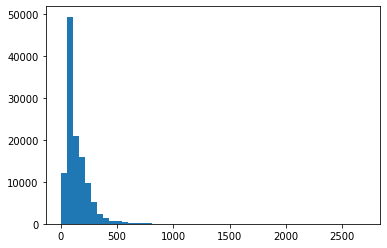

In [53]:
df['price'].hist(bins=50, grid=False)

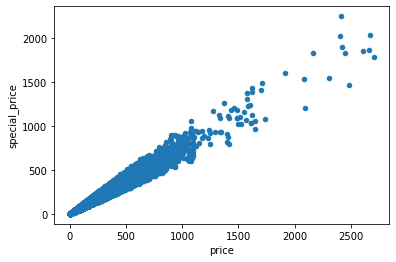

In [54]:
df.plot(x='price', y='special_price', kind='scatter')

In [55]:
add_outlier = np.random.binomial(1, 0.05, size=len(df['price'],))
df['price'] = df['price'] + add_outlier*df['price']*(10000-1)

add_outlier = np.random.binomial(1, 0.05, size=len(df['special_price'],))
df['special_price'] = df['special_price'] + add_outlier*df['special_price']*(10000-1)

df.head()

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
0,2AF8EBDBE57CC56A2357DE986AD0570C,Produto Taun We Box,Taun We,<H3>Transporte Seus Pertences Com Estilo Usand...,Unissex,Azul,109.99,74.99,Sports Accessories,7.1,82.9,357.8,276.1,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,Setor M,Mochila
1,62D15191D7E772D1550C6BC43E313D11,Produto Luke Skywalker Piping,Luke Skywalker,<H3>Esbanje Estilo E Atitude Por Aí Com O Prod...,Masculino,Branco,129.99,84.99,Sports Accessories,1.9,149.8,23.5,134.9,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,Setor P,Boné
2,EA51FF4DAE82DA43460709459186E49F,Produto Padmé Tricot Aleta Courinho,Padmé,<H3>Com A Produto Padmé Tricot Aleta Courinho\...,Feminino,Marrom,189.99,154.99,Sports Apparel,2.8,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,Setor H,Blusa
3,2B6E91B4AEB1BF52A15631C009E04129,Produto Regata Luke Skywalker In The Zone,Luke Skywalker,<Strong>Produto Regata Luke Skywalker In The Z...,Masculino,Amarelo Claro,89.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,Setor N,Camiseta
4,7741851644EBA94C29D17E5F3BB144F7,Produto Luke Skywalker Recess Full Five,Luke Skywalker,<H3>Leve Tudo O Que Você Precisa Com Muito Est...,Unissex,Colorido,119.99,114.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,Setor N,Mochila


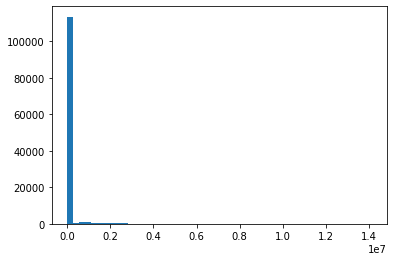

In [56]:
df['price'].hist(bins=50, grid=False)

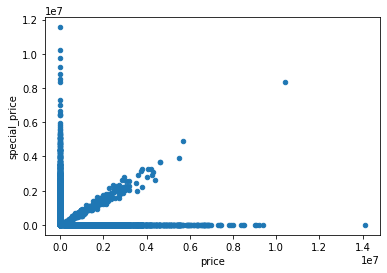

In [57]:
df.plot(x='price', y='special_price', kind='scatter')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119272 entries, 0 to 165034
Data columns (total 16 columns):
product_id             119272 non-null object
product_name           119272 non-null object
brand                  119272 non-null object
product_description    119272 non-null object
gender                 119272 non-null object
color                  119079 non-null object
price                  119272 non-null float64
special_price          119272 non-null float64
division               119272 non-null object
box_weight             119272 non-null float64
box_length             119272 non-null float64
box_height             119272 non-null float64
box_width              119272 non-null float64
product_large_image    119272 non-null object
position_in_stock      119272 non-null object
category               119272 non-null object
dtypes: float64(6), object(10)
memory usage: 15.5+ MB


In [59]:
add_missing = np.random.binomial(1, 0.10, size=len(df['box_weight'],))
df.loc[add_missing==1, 'box_weight'] = np.nan

add_missing = np.random.binomial(1, 0.15, size=len(df['box_length'],))
df.loc[add_missing==1, 'box_length'] = np.nan

add_missing = np.random.binomial(1, 0.08, size=len(df['box_height'],))
df.loc[add_missing==1, 'box_height'] = np.nan

add_missing = np.random.binomial(1, 0.12, size=len(df['box_width'],))
df.loc[add_missing==1, 'box_width'] = np.nan

df.head()

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
0,2AF8EBDBE57CC56A2357DE986AD0570C,Produto Taun We Box,Taun We,<H3>Transporte Seus Pertences Com Estilo Usand...,Unissex,Azul,109.99,74.99,Sports Accessories,7.1,82.9,357.8,276.1,http://img.kstatic.com.br/p/0-93862-1-zoom.jpg,Setor M,Mochila
1,62D15191D7E772D1550C6BC43E313D11,Produto Luke Skywalker Piping,Luke Skywalker,<H3>Esbanje Estilo E Atitude Por Aí Com O Prod...,Masculino,Branco,129.99,84.99,Sports Accessories,1.9,149.8,23.5,134.9,http://img.kstatic.com.br/p/0-42946-1-zoom.jpg,Setor P,Boné
2,EA51FF4DAE82DA43460709459186E49F,Produto Padmé Tricot Aleta Courinho,Padmé,<H3>Com A Produto Padmé Tricot Aleta Courinho\...,Feminino,Marrom,189.99,154.99,Sports Apparel,NaN,194.4,23.5,246.4,http://img.kstatic.com.br/p/0-37283-1-zoom.jpg,Setor H,Blusa
3,2B6E91B4AEB1BF52A15631C009E04129,Produto Regata Luke Skywalker In The Zone,Luke Skywalker,<Strong>Produto Regata Luke Skywalker In The Z...,Masculino,Amarelo Claro,89.99,64.99,Sports Apparel,2.3,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-102442-1-zoom.jpg,Setor N,Camiseta
4,7741851644EBA94C29D17E5F3BB144F7,Produto Luke Skywalker Recess Full Five,Luke Skywalker,<H3>Leve Tudo O Que Você Precisa Com Muito Est...,Unissex,Colorido,119.99,114.99,Sports Accessories,10.1,276.1,357.8,82.9,http://img.kstatic.com.br/p/0-4868-1-zoom.jpg,Setor N,Mochila


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119272 entries, 0 to 165034
Data columns (total 16 columns):
product_id             119272 non-null object
product_name           119272 non-null object
brand                  119272 non-null object
product_description    119272 non-null object
gender                 119272 non-null object
color                  119079 non-null object
price                  119272 non-null float64
special_price          119272 non-null float64
division               119272 non-null object
box_weight             107476 non-null float64
box_length             101204 non-null float64
box_height             109751 non-null float64
box_width              104783 non-null float64
product_large_image    119272 non-null object
position_in_stock      119272 non-null object
category               119272 non-null object
dtypes: float64(6), object(10)
memory usage: 15.5+ MB


# Split train and test

In [61]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234, stratify=df['category'])
df_train = df_train.copy()
df_test = df_test.copy()



CATEGORY_HASH_SALT = 'Dafiti_Group%'
CATEGORY_HASH_PEPPER = '@Data_Challenge'

answers = df_test['category'].copy().to_numpy()
df_test['category_hash'] = (CATEGORY_HASH_SALT + df_test['product_id'] + df_test['category'] + CATEGORY_HASH_PEPPER).apply(lambda x: (sha1(x.encode()).hexdigest()).upper())
df_test['category'] = 'PREDICT_VALUE'

assert df_test.category_hash.value_counts().max() == 1

In [62]:
df_train.sample(5)

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
51192,ABBFF1F82D1093E69FC39450550402BC,Produto Leia Milan,Leia,<Strong>Produto Kanui Clothing &Amp; Co. Milan...,Masculino,Preto,44.99,29.99,Men - PL,NaN,16.1,216.7,187.0,http://img.kstatic.com.br/p/0-483302-1-zoom.jpg,Setor G,Camiseta
6231,B6D3A3EA5D57E84867255F797E6D7B44,Produto Luke Skywalker Crushing,Luke Skywalker,"<H3>Produto Luke Skywalker Crushing\, A Adrena...",Masculino,Amarelo Esverdeado,184.99,164.99,Sports Apparel,NaN,201.8,30.9,NaN,http://img.kstatic.com.br/p/0-28407-1-zoom.jpg,Setor O,Bermuda
128150,0D01A29180E63A4D970C5B2449769D3A,Produto <BRAND_000192> Skull,<BRAND_000192>,<H3>Chegue Mais Longe Com A Produto <BRAND_000...,Masculino,Vinho,324.99,209.99,Sports Shoes,9.5,NaN,97.8,NaN,http://img.kstatic.com.br/p/0-532851-1-zoom.jpg,Setor M,Bota
84848,C472480BA2FE5AB67ED952CF3A07DB32,Produto Regata Windu Musique,Windu,<Strong>Produto Regata Windu Musique</Strong>\...,Feminino,Vermelho,84.99,59.99,Sports Apparel,2.8,23.5,246.4,194.4,http://img.kstatic.com.br/p/0-633662-1-zoom.jpg,Setor N,Blusa
159326,CF820A7297E8B6F77458F97FA2A9A0F9,Produto BB8 Tour 23,BB8,<H3>Garanta Maior Praticidade Ao Transportar T...,Unissex,Vermelho,74.99,64.99,Sports Accessories,NaN,357.8,276.1,75.5,http://img.kstatic.com.br/p/0-03301-1-zoom.jpg,Setor M,Mochila


In [63]:
df_test.head()

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category,category_hash
35742,631FB8F77A5A4F8ED6DE427768101834,Produto Sebulba Spin,Sebulba,O <Strong>Produto Sebulba Spin</Strong> É Para...,Feminino,Roxo,109.99,79.99,Sports Shoes,6.4,149.8,90.4,239.0,http://img.kstatic.com.br/p/0-41409-1-zoom.jpg,Setor D,PREDICT_VALUE,05BDF025F31085AAAF7CD5F4F05286719E19252F
90833,CFE6EFAED4FC64D02DC8A5B0117331D3,Produto Bossk Dark Matrix,Bossk,<H3>Vista A Produto Bossk Dark Matrix E Deixe ...,Masculino,Verde,204.99,179.99,Sports Apparel,3.3,201.8,30.9,246.4,http://img.kstatic.com.br/p/0-58956-1-zoom.jpg,Setor I,PREDICT_VALUE,D81D40DD8DD1B6B4CB479C014555603C452B2A9A
145302,4864C65B70BB0B874239A16E0F51F928,Produto Jeans Owen 2X4,Owen,<H3>A Produto Jeans Owen 2X4 Faz A Diferença N...,Masculino,Preto,184.99,164.99,Sports Apparel,3.3,224.1,45.8,NaN,http://img.kstatic.com.br/p/0-80693-1-zoom.jpg,Setor A,PREDICT_VALUE,936A5C2FB335EDA008CF246CF9D0899AD8164774
29571,FC116862B1FEB15E249BE2941AEB215D,Produto Lama Su Vl 2500 Lady,Lama Su,"<H3>Produto Lama Su Vl 2500 Lady\, A Combinaçã...",Feminino,Branco,64.99,49.99,Sports Shoes,6.4,149.8,NaN,239.0,http://img.kstatic.com.br/p/0-54136-1-zoom.jpg,Setor J,PREDICT_VALUE,AA3F0705D66FFF1238409176A42C580E8B2F9F7C
135739,83D4B854506AACC841872A3FB309CAB6,Bolsa Yoda Heritage Si Shoulder Club,Yoda,<Strong>Bolsa Yoda Heritage Si Shoulder Club</...,Feminino,Roxo,174.99,104.99,Sports Accessories,6.7,NaN,30.9,335.5,http://img.kstatic.com.br/p/0-929041-1-zoom.jpg,Setor J,PREDICT_VALUE,234B38810B6AD54912C1F3D4DAFDD80D15EF583F


# Save dataframe

In [64]:
df_train.to_csv('dafiti_catalog_challenge_train.csv.gz', compression='gzip')
df_test.to_csv('dafiti_catalog_challenge_test.csv.gz', compression='gzip')

# Create example solutions

In [65]:
answers

array(['Tênis', 'Bermuda', 'Calça', ..., 'Tênis', 'Casacos e Jaquetas',
       'Tênis'], dtype=object)

In [66]:
categories = df['category'].unique()


df_allcorrect = pd.read_csv('dafiti_catalog_challenge_test.csv.gz', compression='gzip')
df_allrandom = df_allcorrect.copy()

df_allcorrect['category'] = answers
df_allrandom['category'] = np.random.choice(categories, df_allrandom.shape[0], replace=True)

df_allcorrect.to_csv('dafiti_catalog_challenge_allcorrect.csv.gz', compression='gzip')
df_allrandom.to_csv('dafiti_catalog_challenge_allrandom.csv.gz', compression='gzip')

In [67]:
df_train.sample(5)

,product_id,product_name,brand,product_description,gender,color,price,special_price,division,box_weight,box_length,box_height,box_width,product_large_image,position_in_stock,category
130024,5C31C0A697F70FF7227EFA207BE953F5,Produto Yoda Wmns Free 5.0 Tr Fit 5 Print,Yoda,O <Strong>Produto Yoda Wmns Free 5.0 Tr Fit 5 ...,Feminino,Roxo,369.99,314.99,Sports Shoes,6.4,239.0,90.4,NaN,http://img.kstatic.com.br/p/0-472741-1-zoom.jpg,Setor K,Tênis
135715,A7E7B06FE93ED763FA379EB833BFD4F3,Produto Luke Skywalker Tyraid,Luke Skywalker,<H3>Tenha Um Visual Cheio De Atitude Com A Pro...,Masculino,Preto,79.99,49.99,Sports Apparel,2.8,194.4,246.4,23.5,http://img.kstatic.com.br/p/0-56771-1-zoom.jpg,Setor H,Camiseta
7298,C9620499EEF0C0C9A733D6AB63BA786F,Produto IG-88 Estampada 8863,IG-88,<Strong>Produto IG-88 Estampada 8863</Strong>\...,Masculino,Verde,39.99,34.99,Sports Apparel,2.3,NaN,216.7,187.0,http://img.kstatic.com.br/p/0-149941-1-zoom.jpg,Setor I,Camiseta
149100,FB4575F5BD4270634ADB225F65B8AA0F,Produto Beru Why Stroll,Beru,<H3>Atitude Em Destaque Com A Produto Beru Why...,Masculino,Branco,119.99,94.99,Sports Apparel,2.6,16.1,187.0,216.7,http://img.kstatic.com.br/p/0-33468-1-zoom.jpg,Setor C,Camiseta
137779,0653DD290FE9088356C012869E3E719F,Produto Biggs Super Coil,Biggs,<H3>Teus Pés Merecem Todo O Toque Moderno Do P...,Masculino,Preto,194.99,144.99,Sports Shoes,6.8,164.7,253.8,97.8,http://img.kstatic.com.br/p/0-46057-1-zoom.jpg,Setor M,Chinelo
